In [21]:
import numpy as np
import cv2
import datetime
import matplotlib.pyplot as plt
from cartpole_lib_python import *
import odrive

In [2]:
init_odrive()

axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.SUCCESS
  last_drv_fault: none
internal issues: none
axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.CANCELLED
  last_drv_fault: none
internal issues: none
odrive initialized


In [3]:
odrv = get_odrive()
odrive.utils.dump_errors(odrv)

axis0
  active_errors: no error
  disarm_reason: no error
  procedure_result: ProcedureResult.CANCELLED
  last_drv_fault: none
internal issues: none


In [4]:
# Set up camera stream
gst_string = 'v4l2src ! video/x-raw, format=GRAY8, width=640, height=400, framerate=60/1 ! videoconvert ! videoflip method=2 ! appsink sync=false'
cap = cv2.VideoCapture(gst_string, cv2.CAP_GSTREAMER)
if not cap.isOpened():
    print("Cannot open camera")
    exit()

# Load calibration data
calib_data = np.load("calibration_data.npz")
mtx = calib_data["matrix"]
dist = calib_data["coefficients"]

# Initialize image undistortion matrix map
ret, frame = cap.read()
h, w = frame.shape
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
mapx, mapy = cv2.initUndistortRectifyMap(mtx, dist, None, newcameramtx, (w,h), 5)
x_roi, y_roi, w_roi, h_roi = roi

# Define image cropping parameters
right_side_off = 20
left_side_off = 20

In [5]:
print(get_state())

[-0.07219373781638427, 4.710854999596804, -3.3772921389010896e-11, 1.6528372860509837e-09]


1.5416506918250694

In [6]:
control_frequency = 60 # Hz
control_period = 1/control_frequency
T = 60 # runtime, seconds
N = int(T*control_frequency)
print("N: ", N)

xg = np.array([0, 1.5416506918250694, 0, 0])

# 60 hz
k_matrix = np.array([-3.43659, -34.39494, -5.15817, -8.42840]) * 0.2 # .2 is a multiplier to convert from force to motor torque (not sure what it should actually be)
A = np.array([[1.00000, -0.00096, 0.01667, -0.00001],
            [0.00000, 1.00499, 0.00000, 0.01669],
            [0.00000, -0.11483, 1.00000, -0.00096],
            [0.00000, 0.59871, 0.00000, 1.00499]])
B = np.array([[0.00035],
            [-0.00076],
            [0.04260],
            [-0.09164]])

H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0]])

meas_noise_cov = np.diag([.1,.1]) # most recent
process_noise_cov = np.diag([1,1,50,50]) # position, angle, linear velocity, angular velocity

nx = process_noise_cov.shape[0]
def kf_update(x_meas, x_pred_prev, est_cov_prev):
    Kn = est_cov_prev@H.T @ np.linalg.inv(H@est_cov_prev@H.T + meas_noise_cov)
    x = x_pred_prev + Kn @ (x_meas - H@x_pred_prev)
    est_cov = (np.eye(nx) - Kn@H) @ est_cov_prev @ (np.eye(nx) - Kn@H).T + Kn@meas_noise_cov@Kn.T
    return x, est_cov

def kf_predict(state, control, est_cov):
    x_pred = A@state + B@control
    est_cov_pred = A@est_cov@A.T + process_noise_cov
    return x_pred, est_cov_pred

# Initialize Kalman filter variables
# First state estimate
meas = get_measurement() - xg[:2]
x = np.array([meas[0], meas[1], 0, 0])
x_pred_prev = x
# Estimation covariance
est_cov = np.eye(4)*20
est_cov_prev = est_cov

# Initialize numpy arrays to keep track of data
xs = np.zeros(np.append(x.shape, N))
measurements = np.zeros((2,N))
controls = np.zeros(N)
control_clamp = .15

# Initialize python arrays to keep track of timing
read_times = []
thresh_times = []
control_times = []
loop_times = []

# Initialize python array to store image frames
frames = []
    
for i in range(N):
    time_start = time.perf_counter()
    
    # Capture frame
    ret, frame = cap.read()
    read_times.append(time.perf_counter() - time_start)
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame. Exiting...")
        command_linear_torque(0)
        break
    
    # Undistort and crop frame
    frame_undistort = cv2.remap(frame, mapx, mapy, cv2.INTER_LINEAR)
    frame_undistort = frame_undistort[y_roi:y_roi+h_roi, x_roi:x_roi+w_roi]
    frame_undistort = cv2.resize(frame_undistort, (200, 125), # 1.6 aspect ratio (same as camera (640x400))
               interpolation=cv2.INTER_LINEAR)
    frame_undistort = frame_undistort[:, left_side_off:-right_side_off] # final image size is 200-left_side_off-right_side_off x 125-top_off-bottom_off (currently 160x125)

    # Threshold frame
    ret, thresh_image = cv2.threshold(frame_undistort, 37, 255, cv2.THRESH_BINARY)
    frames.append(thresh_image)
    thresh_times.append(time.perf_counter() - time_start)
    # frame_for_visualization = cv2.resize(thresh_image, (640-right_side_off-left_side_off, 400), interpolation=cv2.INTER_CUBIC)
    # cv2.imshow('frame', frame_for_visualization)
    # cv2.imshow('frame', frame_undistort)
    # if cv2.waitKey(1) == ord('q'):
    #     break
    
    measurement = get_measurement() - xg[:2]
    if i > 0:
        x, est_cov = kf_update(measurement, x_pred_prev, est_cov_prev)
    
    x[3] /= 2
    xs[:,i] = x
    measurements[:,i] = measurement
    control = -k_matrix @ x
    control = min(control_clamp, max(-control_clamp, control))
    
    x_pred_prev, est_cov_prev = kf_predict(x, [control], est_cov)
    
    command_linear_torque(-control)
    # command_linear_torque(0)
    controls[i] = control
    control_times.append(time.perf_counter() - time_start)
    
    busy_sleep(control_period, time_start, get_now=time.perf_counter)
    loop_times.append(time.perf_counter() - time_start)

command_linear_torque(0)

N:  3600


In [23]:
# Save data to npz to transfer to laptop
now = datetime.datetime.now()
file_name = "data_from_jetson/cartpole_train_data_" + now.strftime("%m-%d-%Y_%H-%M-%S") + ".npz"
np.savez(file_name, frames=frames, controls=controls, measurements=measurements, est_states=xs)

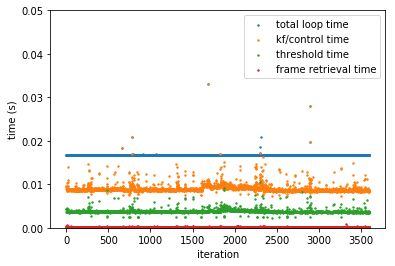

In [7]:
plt.scatter(range(len(loop_times)), np.array(loop_times), s=2, label="total loop time")
plt.scatter(range(len(loop_times)), np.array(control_times), s=2, label="kf/control time")
plt.scatter(range(len(loop_times)), np.array(thresh_times), s=2, label="threshold time")
plt.scatter(range(len(loop_times)), np.array(read_times), s=2, label="frame retrieval time")

plt.ylim([0,.05])
plt.legend()
plt.ylabel("time (s)")
plt.xlabel("iteration")

plt.show()

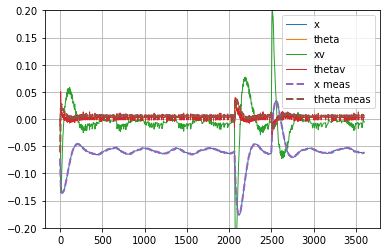

In [19]:
plt.plot(xs.T, '-', linewidth=1)
plt.plot(measurements.T, '--', linewidth=2)
plt.ylim([-.2,.2])
# plt.legend(['x', 'theta', 'xv', 'thetav'])
plt.legend(['x', 'theta', 'xv', 'thetav', 'x meas', 'theta meas'])
plt.grid()
plt.show()

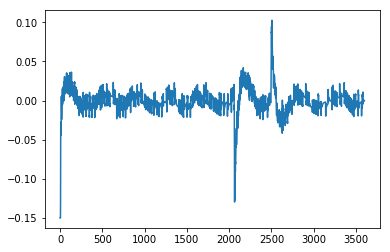

In [18]:
plt.plot(controls)